# Set up variables / Load data splits

In [1]:
!module list

Currently Loaded Modulefiles:
 1) courses/cs435/pa3   3) ide/visual-studio-code  
 2) python/bundle-3.9   4) cuda/11.2               
>

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold
import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import classification_report


2023-11-17 15:13:37.379042: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
shared_dir = "/s/bach/a/class/cs435/cs435a/"
image_dir = "CS435_Plant_Data_v2_augment-v2/2023-11-15-231056/"

model_name = "trained_augmented"
train_path= shared_dir+image_dir+"splits/augmented/aug_train.csv"
valid_path= shared_dir+image_dir+"splits/augmented/aug_valid.csv"

# model_name = "trained_original"
# train_path= shared_dir+image_dir+"splits/original/orig_train.csv"
# valid_path= shared_dir+image_dir+"splits/original/orig_valid.csv"

orig_test_path= shared_dir+image_dir+"splits/original/orig_test.csv"
aug_test_path= shared_dir+image_dir+"splits/augmented/aug_test.csv"

In [5]:
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(valid_path)
orig_test_df = pd.read_csv(orig_test_path)
aug_test_df = pd.read_csv(aug_test_path)
print(train_df.shape)
print(val_df.shape)
print(aug_test_df.shape)
print(orig_test_df.shape)

(172639, 13)
(21580, 13)
(21580, 13)
(7166, 13)


In [6]:
datagen = ImageDataGenerator(rescale=1./255) #normalize from [0,255] to [0,1]

In [7]:
batchsize=128

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='path_to_shared',
    y_col='class_name',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=batchsize
)
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='path_to_shared',
    y_col='class_name',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=batchsize
)
# test_generator = datagen.flow_from_dataframe(
#     dataframe=test_df,
#     directory=None,
#     x_col='path_to_shared',
#     y_col='class_name',
#     target_size=(224, 224),
#     class_mode='categorical',
#     batch_size=batchsize
# )

aug_test_generator = datagen.flow_from_dataframe(
    dataframe=aug_test_df, 
    x_col='path_to_shared',
    y_col='class_name',  
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical', 
    shuffle=False
)

orig_test_generator = datagen.flow_from_dataframe(
    dataframe=orig_test_df, 
    x_col='path_to_shared',
    y_col='class_name',  
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical', 
    shuffle=False
)

Found 172639 validated image filenames belonging to 31 classes.
Found 21580 validated image filenames belonging to 31 classes.
Found 21580 validated image filenames belonging to 31 classes.
Found 7166 validated image filenames belonging to 31 classes.


In [8]:
train_class_dict = train_generator.class_indices
val_class_dict = val_generator.class_indices
aug_test_class_dict = aug_test_generator.class_indices
orig_test_class_dict = orig_test_generator.class_indices
print(train_class_dict)
print(val_class_dict)
print(aug_test_class_dict)
print(orig_test_class_dict)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Cherry_(including_sour)___Powdery_mildew': 4, 'Cherry_(including_sour)___healthy': 5, 'Corn_(maize)___Common_rust_': 6, 'Corn_(maize)___Northern_Leaf_Blight': 7, 'Corn_(maize)___healthy': 8, 'Grape___Black_rot': 9, 'Grape___Esca_(Black_Measles)': 10, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 11, 'Grape___healthy': 12, 'Peach___Bacterial_spot': 13, 'Peach___healthy': 14, 'Pepper,_bell___Bacterial_spot': 15, 'Pepper,_bell___healthy': 16, 'Potato___Early_blight': 17, 'Potato___Late_blight': 18, 'Potato___healthy': 19, 'Strawberry___Leaf_scorch': 20, 'Strawberry___healthy': 21, 'Tomato___Bacterial_spot': 22, 'Tomato___Early_blight': 23, 'Tomato___Late_blight': 24, 'Tomato___Leaf_Mold': 25, 'Tomato___Septoria_leaf_spot': 26, 'Tomato___Target_Spot': 27, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 28, 'Tomato___Tomato_mosaic_virus': 29, 'Tomato___healthy': 30}
{'Apple___Apple_scab': 0, 'A

# Load Model

In [9]:
base_model=tf.keras.applications.VGG16(weights="imagenet",include_top=False,input_shape=(224,224,3))
base_model.trainable=False

2023-11-17 15:14:38.944424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 15:14:39.582055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46709 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:18:00.0, compute capability: 8.6


In [10]:
vgg_model=keras.models.Sequential()
vgg_model.add(base_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(4096,activation='relu'))
vgg_model.add(Dense(31,activation='softmax'))
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 31)                127007    
                                                                 
Total params: 117,606,239
Trainable params: 102,891,551
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
vgg_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                #   loss=SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [12]:
from keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.1,
                              patience=3,
                              mode='max',
                              restore_best_weights=True
                              )

# Train Model

In [13]:
model_history = vgg_model.fit(
    train_generator,
#     steps_per_epoch=train_num//batch_size,
    validation_data=val_generator,
    epochs=6,
#     validation_steps=valid_num//batch_size,
    callbacks=[earlystopping]
)

Epoch 1/6


2023-11-17 15:14:44.135341: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


   2/1349 [..............................] - ETA: 3:20 - loss: 14.5646 - accuracy: 0.0586  

2023-11-17 15:14:48.047713: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1349/1349 [==============================] - 1023s 755ms/step - loss: 0.6535 - accuracy: 0.8818 - val_loss: 0.2139 - val_accuracy: 0.9275
Epoch 2/6
1349/1349 [==============================] - 326s 241ms/step - loss: 0.1308 - accuracy: 0.9555 - val_loss: 0.1549 - val_accuracy: 0.9481
Epoch 3/6
1349/1349 [==============================] - 344s 255ms/step - loss: 0.0929 - accuracy: 0.9679 - val_loss: 0.1837 - val_accuracy: 0.9402
Epoch 4/6
1349/1349 [==============================] - 325s 241ms/step - loss: 0.0786 - accuracy: 0.9727 - val_loss: 0.1518 - val_accuracy: 0.9549


In [14]:
vgg_model.save("/s/bach/a/class/cs435/cs435a/models/"+model_name+".h5")

In [15]:
# from tensorflow.keras.models import load_model
# vgg_model = load_model('trained_model.h5')

# Evaluate Model
## Training metrics

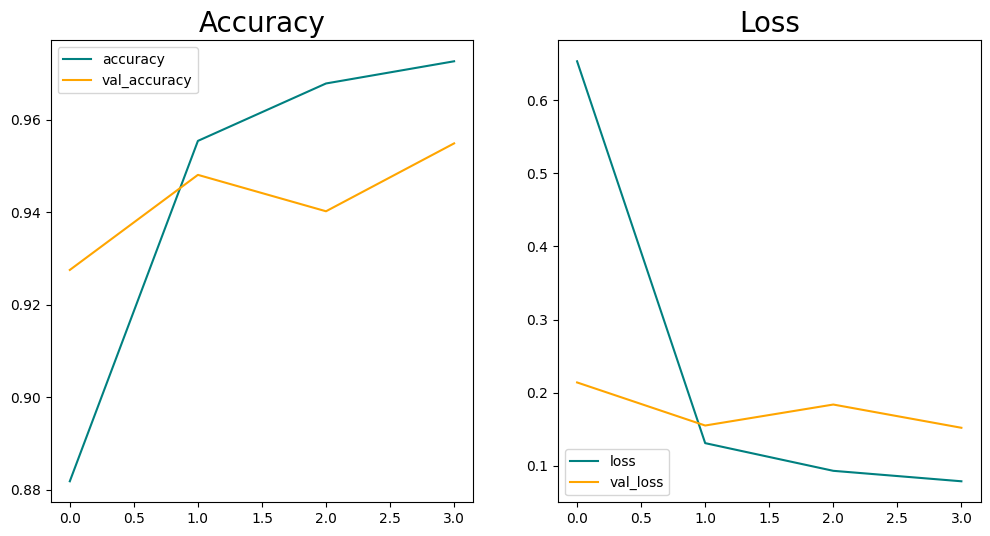

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
 
plt.subplot(121)
plt.plot(model_history.history['accuracy'], color='teal', label='accuracy')
plt.plot(model_history.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.legend(loc='upper left')
 
plt.subplot(122)
plt.plot(model_history.history['loss'], color='teal', label='loss')
plt.plot(model_history.history['val_loss'], color='orange', label='val_loss')
# plt.yscale('log')
plt.title('Loss', fontsize=20)
plt.legend(loc='lower left')

plt.savefig(model_name+"_training_plots.png")
plt.show()

## Evaluate with Un-Augmented test split

In [17]:
orig_predictions = vgg_model.predict(orig_test_generator)

1792/1792 [==============================] - 14s 7ms/step


In [18]:

predicted_classes = np.argmax(orig_predictions, axis=1)

label_map = {label: index for index, label in enumerate(orig_test_generator.class_indices)}

true_classes = orig_test_df['class_name'].map(label_map).values

conf_matrix = confusion_matrix(true_classes, predicted_classes)

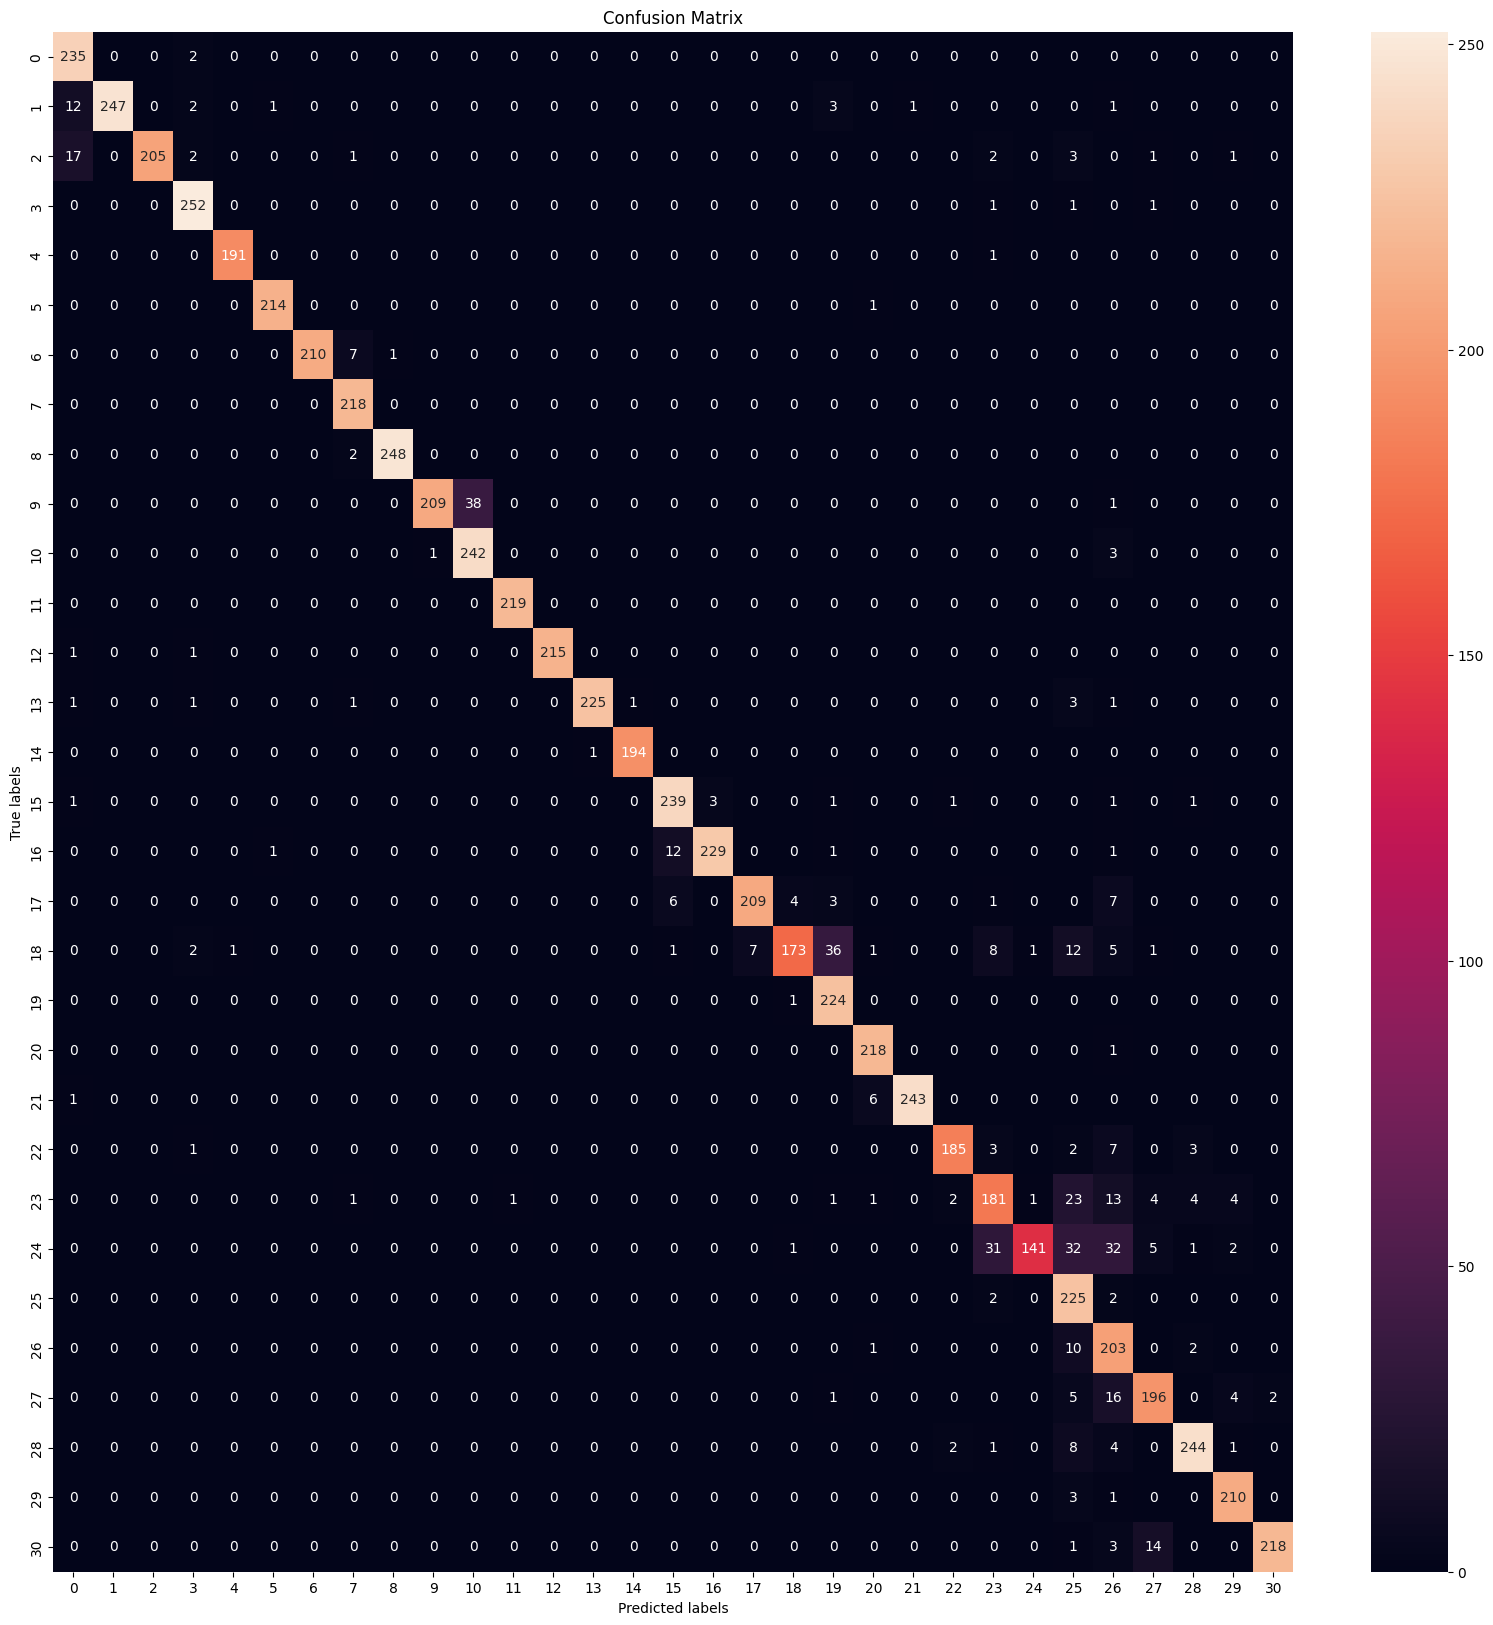

In [19]:
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.savefig(model_name+'_orig_confusion_matrix.png')
plt.show()

In [20]:
# acc = [1 if true_classes[i] == predicted_classes[i] else 0 for i in range(len(true_classes))]
# np.mean(acc)
accuracy = np.mean(predicted_classes == true_classes)
accuracy

0.9296678760814959

In [21]:
report = classification_report(true_classes, predicted_classes, target_names=orig_test_generator.class_indices.keys())

print(report)
with open(model_name+'_orig_classification_report.txt', 'w') as f:
    f.write(report)

                                            precision    recall  f1-score   support

                        Apple___Apple_scab       0.88      0.99      0.93       237
                         Apple___Black_rot       1.00      0.93      0.96       267
                  Apple___Cedar_apple_rust       1.00      0.88      0.94       232
                           Apple___healthy       0.96      0.99      0.97       255
  Cherry_(including_sour)___Powdery_mildew       0.99      0.99      0.99       192
         Cherry_(including_sour)___healthy       0.99      1.00      0.99       215
               Corn_(maize)___Common_rust_       1.00      0.96      0.98       218
       Corn_(maize)___Northern_Leaf_Blight       0.95      1.00      0.97       218
                    Corn_(maize)___healthy       1.00      0.99      0.99       250
                         Grape___Black_rot       1.00      0.84      0.91       248
              Grape___Esca_(Black_Measles)       0.86      0.98      0.92  

## Evaluate with Augmented test split

In [22]:
aug_predictions = vgg_model.predict(aug_test_generator)

21580/21580 [==============================] - 78s 4ms/step


In [23]:
predicted_classes = np.argmax(aug_predictions, axis=1)

label_map = {label: index for index, label in enumerate(aug_test_generator.class_indices)}

true_classes = aug_test_df['class_name'].map(label_map).values

conf_matrix = confusion_matrix(true_classes, predicted_classes)

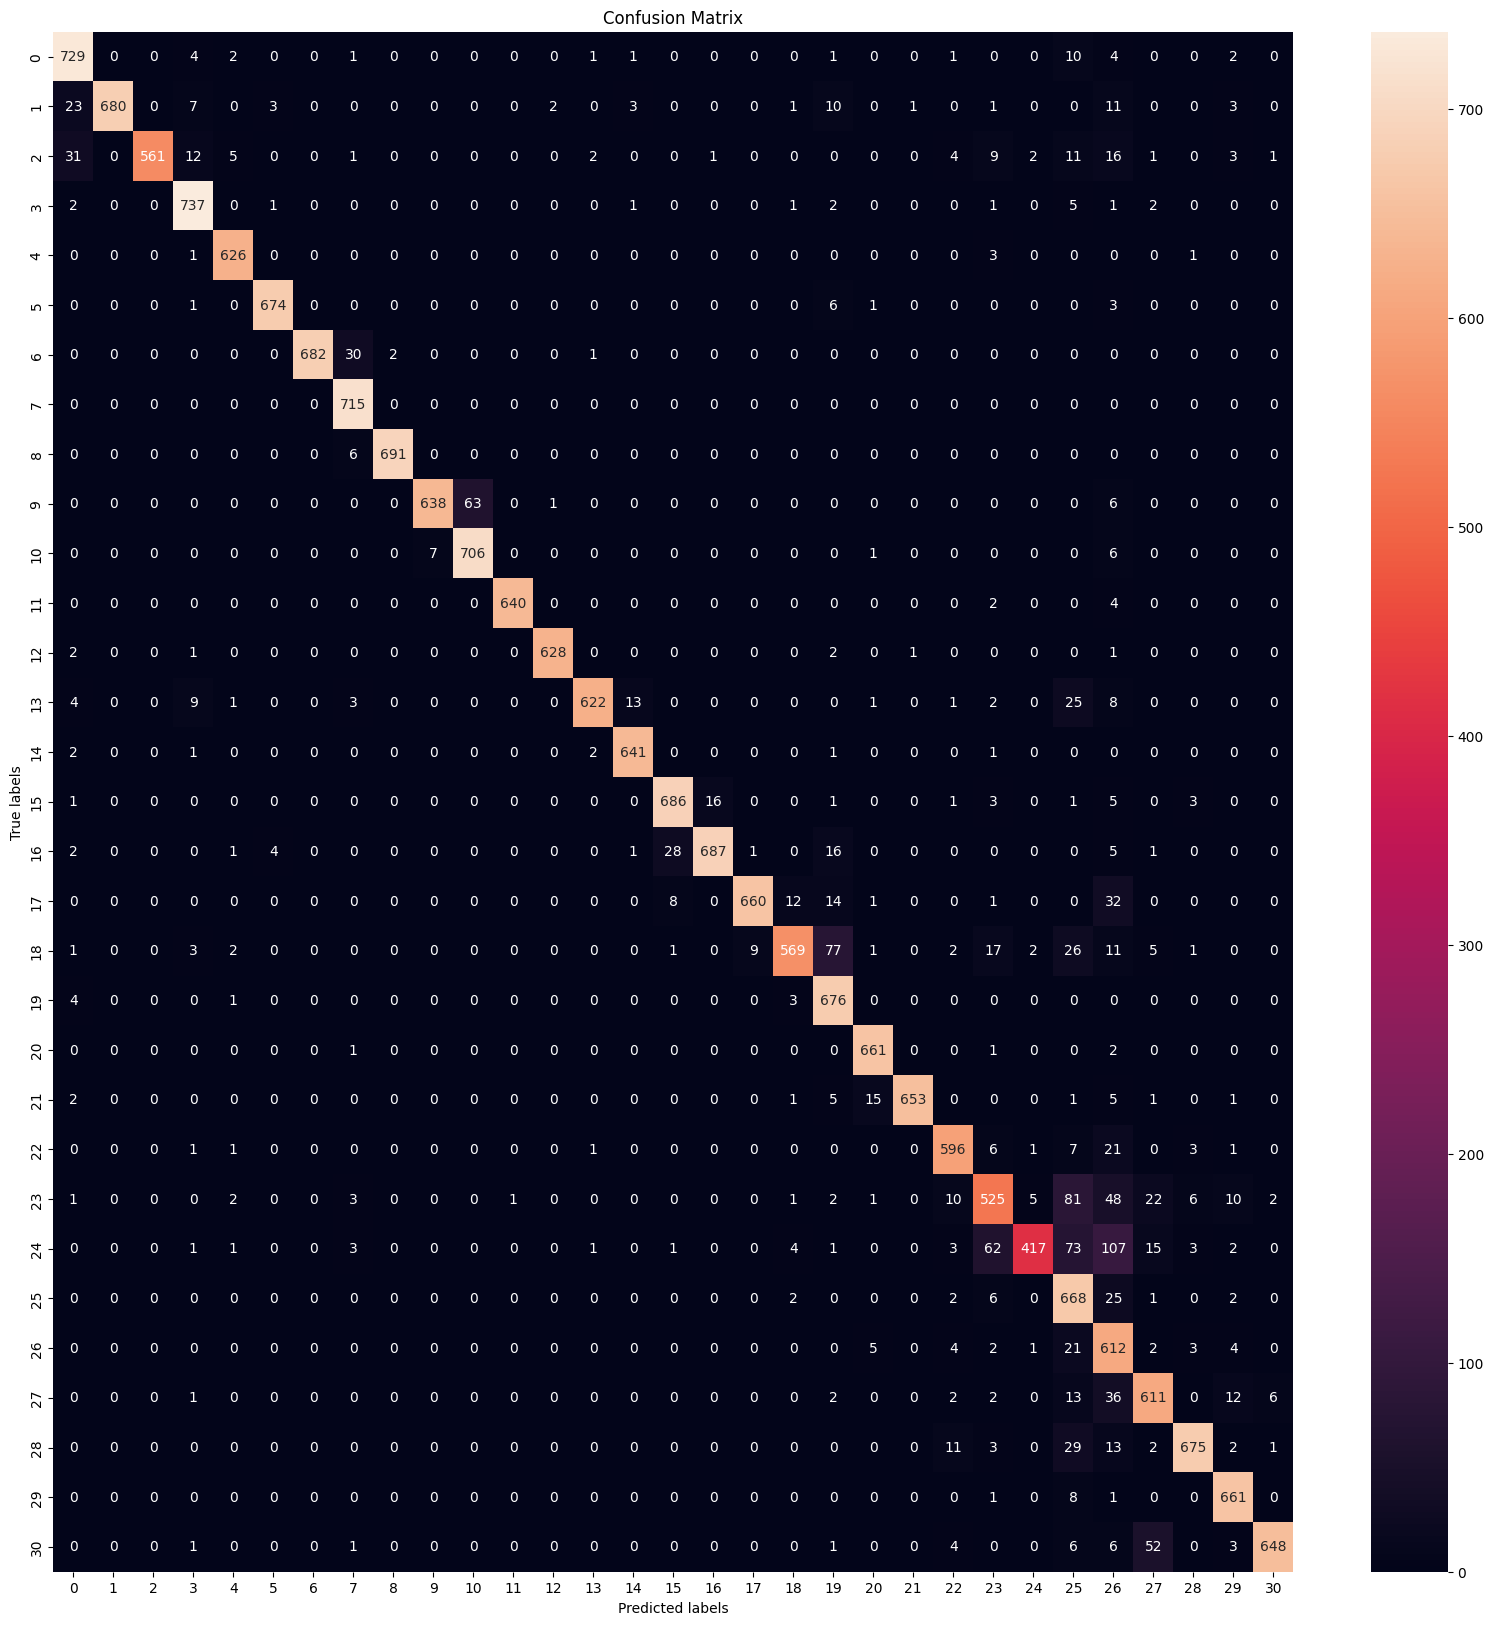

In [24]:
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.savefig(model_name+'_aug_confusion_matrix.png')
plt.show()

In [25]:
# acc = [1 if true_classes[i] == predicted_classes[i] else 0 for i in range(len(true_classes))]
# np.mean(acc)
accuracy = np.mean(predicted_classes == true_classes)
accuracy

0.9256255792400371

In [26]:
report = classification_report(true_classes, predicted_classes, target_names=orig_test_generator.class_indices.keys())

print(report)
with open(model_name+'_aug_classification_report.txt', 'w') as f:
    f.write(report)

                                            precision    recall  f1-score   support

                        Apple___Apple_scab       0.91      0.96      0.93       756
                         Apple___Black_rot       1.00      0.91      0.95       745
                  Apple___Cedar_apple_rust       1.00      0.85      0.92       660
                           Apple___healthy       0.94      0.98      0.96       753
  Cherry_(including_sour)___Powdery_mildew       0.98      0.99      0.98       631
         Cherry_(including_sour)___healthy       0.99      0.98      0.99       685
               Corn_(maize)___Common_rust_       1.00      0.95      0.98       715
       Corn_(maize)___Northern_Leaf_Blight       0.94      1.00      0.97       715
                    Corn_(maize)___healthy       1.00      0.99      0.99       697
                         Grape___Black_rot       0.99      0.90      0.94       708
              Grape___Esca_(Black_Measles)       0.92      0.98      0.95  